## CMSE 410 Project
#### Katherine Perry

## Working with the UCI Molecular Biology Splice-Junction Sequences dataset

In this notebook I will load in the dataset using an approach adapted from the approach in the Promoter notebook. Then I will run a variety of modelling algorithms and analyze the outputs.

In [23]:
import sys
import numpy as np
import sklearn
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
url2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data"
names = ['Class', 'id', 'Sequence']
data = pd.read_csv(url2, names = names)
print(data.iloc[0])

Class                                                      EI
id                                           ATRINS-DONOR-521
Sequence                   CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
Name: 0, dtype: object


In [3]:
classes = data.loc[:, 'Class']
# generate list of DNA sequences
sequences = list(data.loc[:, 'Sequence'])
dataset = {}

# loop through sequences and split into individual nucleotides
for i, seq in enumerate(sequences):
    
    # split into nucleotides, remove tab characters
    nucleotides = list(seq)
    nucleotides = [x for x in nucleotides if x != '\t']
    
    # append class assignment
    nucleotides.append(classes[i])
    
    # add to dataset
    dataset[i] = nucleotides

# get rid of spaces which make arrays different lengths
for i in range(len(dataset)):
    j = 0
    while j < len(dataset[i]):
        if dataset[i][j] == ' ':
            dataset[i].remove(' ')
            j-=1
        j+=1
        
# turn dataset into pandas DataFrame
dframe = pd.DataFrame(dataset)
# transpose the DataFrame
df = dframe.transpose()
# for clarity, lets rename the last dataframe column to class
df.rename(columns = {60: 'Class'}, inplace = True) 
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,Class
count,3190,3190,3190,3190,3190,3190,3190,3190,3190,3190,...,3190,3190,3190,3190,3190,3190,3190,3190,3190,3190
unique,5,5,4,4,4,4,4,4,4,4,...,5,5,5,5,5,5,5,5,5,3
top,G,C,C,C,C,C,C,C,C,T,...,G,G,G,G,G,G,C,C,G,N
freq,876,858,876,884,865,898,858,878,909,849,...,874,874,934,859,838,908,870,860,953,1655


In [4]:
# convert strings to number data
numerical_df = pd.get_dummies(df)
df = numerical_df.drop(columns=['Class_IE'])
df = numerical_df.drop(columns=['Class_N'])

df.rename(columns = {'Class_EI': 'Class'}, inplace = True)
print(df.iloc[:5])

   0_A  0_C  0_D  0_G  0_T  1_A  1_C  1_D  1_G  1_T  ...  58_G  58_N  58_T  \
0    0    1    0    0    0    0    1    0    0    0  ...     0     0     1   
1    1    0    0    0    0    0    0    0    1    0  ...     1     0     0   
2    0    0    0    1    0    1    0    0    0    0  ...     0     0     1   
3    0    0    0    1    0    0    0    0    1    0  ...     0     0     0   
4    0    0    0    1    0    0    1    0    0    0  ...     0     0     0   

   59_A  59_C  59_G  59_N  59_T  Class  Class_IE  
0     0     0     1     0     0      1         0  
1     0     1     0     0     0      1         0  
2     0     0     1     0     0      1         0  
3     0     1     0     0     0      1         0  
4     0     0     0     0     1      1         0  

[5 rows x 289 columns]


In [5]:
# Use the model_selection module to separate training and testing datasets
from sklearn import model_selection

# Create X and Y datasets for training
X = np.array(df.drop(['Class'], 1))
y = np.array(df['Class'])

# define seed for reproducibility
seed = 1

# split data into training and testing datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=seed)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# define scoring method
scoring = 'accuracy'

# Define models to train
names = ["Nearest Neighbors",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "SVM Linear", "SVM RBF", "SVM Sigmoid"]

classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    SVC(kernel = 'linear'), 
    SVC(kernel = 'rbf'),
    SVC(kernel = 'sigmoid')
]

models = zip(names, classifiers)
# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print('Test-- ',name,': ',accuracy_score(y_test, predictions))
    print()
    print(classification_report(y_test, predictions))

Nearest Neighbors: 0.881688 (0.020139)
Test--  Nearest Neighbors :  0.8834586466165414

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       607
           1       0.69      0.92      0.79       191

    accuracy                           0.88       798
   macro avg       0.83      0.89      0.85       798
weighted avg       0.90      0.88      0.89       798

Decision Tree: 0.983696 (0.006046)
Test--  Decision Tree :  0.9837092731829574

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       607
           1       0.95      0.98      0.97       191

    accuracy                           0.98       798
   macro avg       0.97      0.98      0.98       798
weighted avg       0.98      0.98      0.98       798

Random Forest: 0.759217 (0.025522)
Test--  Random Forest :  0.7606516290726817

              precision    recall  f1-score   support

           0       0.76      1.00      0.86

C:\Users\kaper\python\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Neural Net: 0.982442 (0.005839)
Test--  Neural Net :  0.9849624060150376

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       607
           1       0.96      0.98      0.97       191

    accuracy                           0.98       798
   macro avg       0.98      0.98      0.98       798
weighted avg       0.99      0.98      0.99       798

AdaBoost: 0.984531 (0.007486)
Test--  AdaBoost :  0.9837092731829574

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       607
           1       0.94      0.99      0.97       191

    accuracy                           0.98       798
   macro avg       0.97      0.99      0.98       798
weighted avg       0.98      0.98      0.98       798

Naive Bayes: 0.965720 (0.006684)
Test--  Naive Bayes :  0.9649122807017544

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       607
           1     

C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The defa

SVM RBF: 0.984535 (0.007932)


C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Test--  SVM RBF :  0.9824561403508771

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       607
           1       0.94      0.98      0.96       191

    accuracy                           0.98       798
   macro avg       0.97      0.98      0.98       798
weighted avg       0.98      0.98      0.98       798



C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The defa

SVM Sigmoid: 0.980771 (0.005660)


C:\Users\kaper\python\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Test--  SVM Sigmoid :  0.9799498746867168

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       607
           1       0.95      0.97      0.96       191

    accuracy                           0.98       798
   macro avg       0.97      0.98      0.97       798
weighted avg       0.98      0.98      0.98       798



In [7]:
# %load partSix.py
# Neural Networks Demystified
# Part 6: Training
#
# Supporting code for short YouTube series on artificial neural networks.
#
# Stephen Welch
# @stephencwelch


## ----------------------- Part 1 ---------------------------- ##
import numpy as np


## ----------------------- Part 5 ---------------------------- ##

class Neural_Network(object):
    def __init__(self, layer_i = 2, layer_o = 1, layer_h = 3):        
        #Define Hyperparameters
        self.inputLayerSize = layer_i
        self.outputLayerSize = layer_o
        self.hiddenLayerSize = layer_h
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad 
        
## ----------------------- Part 6 ---------------------------- ##
from scipy import optimize


class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res



In [8]:
train_vectors, test_vectors, train_labels, test_labels = model_selection.train_test_split(X, y, test_size=0.25, random_state=seed)

In [9]:
print(train_vectors.shape)
print(train_labels.shape)
print(test_labels.shape)
train_labels = train_labels/10
test_labels = test_labels/10

(2392, 288)
(2392,)
(798,)


In [10]:
train_labels = train_labels.reshape(2392,1)
test_labels = test_labels.reshape(798, 1)
print(train_labels.shape)

(2392, 1)


In [11]:
#Run the training. 
NN = Neural_Network(288, 1, 1)
T = trainer(NN)
T.train(train_vectors, train_labels)

         Current function value: 1.913927
         Iterations: 200
         Function evaluations: 247
         Gradient evaluations: 247


In [12]:
pred_labels = NN.forward(train_vectors)

print("Training Data error", np.sum((train_labels - pred_labels)*(train_labels-pred_labels))/len(train_vectors))
pred_labels = NN.forward(test_vectors)

print("Testing Data error", np.sum((test_labels - pred_labels)*(test_labels-pred_labels))/len(test_vectors))

Training Data error 0.0016002737882931006
Testing Data error 0.0025986885412775064


In [13]:
from sklearn.metrics import classification_report, accuracy_score
print('Test-- Artificial Neural Network:', 1 - np.sum((test_labels - pred_labels)*(test_labels-pred_labels))/len(test_vectors))

Test-- Artificial Neural Network: 0.9974013114587225


In [15]:
#Run the training with 2 hidden layers
NN = Neural_Network(288, 1, 2)
T = trainer(NN)
T.train(train_vectors, train_labels)

pred_labels = NN.forward(train_vectors)
print("Training Data error", np.sum((train_labels - pred_labels)*(train_labels-pred_labels))/len(train_vectors))
pred_labels = NN.forward(test_vectors)
print("Testing Data error", np.sum((test_labels - pred_labels)*(test_labels-pred_labels))/len(test_vectors))


         Current function value: 0.148211
         Iterations: 200
         Function evaluations: 296
         Gradient evaluations: 296
Training Data error 0.0001239221486192761
Testing Data error 0.00029448142484574444


In [16]:
from sklearn.metrics import classification_report, accuracy_score
print('Test-- Artificial Neural Network:', 1 - np.sum((test_labels - pred_labels)*(test_labels-pred_labels))/len(test_vectors))

Test-- Artificial Neural Network: 0.9997055185751542


In [16]:
# Run the ANN repeatedly with differing numbers of hidden layers
train_accuracies = [0,0,0,0,0]
test_accuracies = [0,0,0,0,0]
timings = [0, 0, 0, 0, 0]
for iterations in range(10):
    for h in range(1,6):
        time0 = time.perf_counter()
        #initialize the neural network
        NN = Neural_Network(288, 1, h)

        # train the model
        T = trainer(NN)
        T.train(train_vectors, train_labels)

        # make the predictions and calculate accuracy
        pred_labels = NN.forward(train_vectors)
        train_accuracies[h-1] += 1-np.sum((train_labels - pred_labels)*(train_labels-pred_labels))/len(train_vectors)
        pred_labels = NN.forward(test_vectors)
        test_accuracies[h-1] += 1-np.sum((test_labels - pred_labels)*(test_labels-pred_labels))/len(test_vectors)
        
        timings[h-1] += time.perf_counter() - time0

         Current function value: 1.920148
         Iterations: 200
         Function evaluations: 266
         Gradient evaluations: 266
Optimization terminated successfully.
         Current function value: 2.186488
         Iterations: 5
         Function evaluations: 17
         Gradient evaluations: 17
         Current function value: 0.031264
         Iterations: 200
         Function evaluations: 231
         Gradient evaluations: 231
         Current function value: 0.049816
         Iterations: 200
         Function evaluations: 235
         Gradient evaluations: 235
Optimization terminated successfully.
         Current function value: 0.084973
         Iterations: 196
         Function evaluations: 222
         Gradient evaluations: 222
Optimization terminated successfully.
         Current function value: 2.186499
         Iterations: 31
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 

C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square


         Current function value: 0.069411
         Iterations: 200
         Function evaluations: 245
         Gradient evaluations: 245
Optimization terminated successfully.
         Current function value: 2.186488
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


         Current function value: 0.118436
         Iterations: 186
         Function evaluations: 266
         Gradient evaluations: 254
Optimization terminated successfully.
         Current function value: 2.186488
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 24
         Current function value: 0.084279
         Iterations: 200
         Function evaluations: 252
         Gradient evaluations: 252
         Current function value: 0.054355
         Iterations: 200
         Function evaluations: 219
         Gradient evaluations: 219
         Current function value: 1.811194
         Iterations: 200
         Function evaluations: 262
         Gradient evaluations: 262


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


         Current function value: 0.332373
         Iterations: 164
         Function evaluations: 256
         Gradient evaluations: 245
         Current function value: 0.074610
         Iterations: 200
         Function evaluations: 286
         Gradient evaluations: 286
         Current function value: 0.044309
         Iterations: 200
         Function evaluations: 267
         Gradient evaluations: 267
         Current function value: 0.107239
         Iterations: 200
         Function evaluations: 271
         Gradient evaluations: 271
         Current function value: 1.958061
         Iterations: 200
         Function evaluations: 267
         Gradient evaluations: 267
         Current function value: 0.065101
         Iterations: 200
         Function evaluations: 228
         Gradient evaluations: 228
Optimization terminated successfully.
         Current function value: 0.114969
         Iterations: 99
         Function evaluations: 116
         Gradient evaluations: 116


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square


Optimization terminated successfully.
         Current function value: 0.128539
         Iterations: 168
         Function evaluations: 246
         Gradient evaluations: 246
Optimization terminated successfully.
         Current function value: 0.231486
         Iterations: 152
         Function evaluations: 214
         Gradient evaluations: 214
         Current function value: 0.134153
         Iterations: 200
         Function evaluations: 239
         Gradient evaluations: 239
         Current function value: 0.044888
         Iterations: 200
         Function evaluations: 233
         Gradient evaluations: 233
         Current function value: 0.029933
         Iterations: 200
         Function evaluations: 204
         Gradient evaluations: 204


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launch

         Current function value: 0.748894
         Iterations: 56
         Function evaluations: 122
         Gradient evaluations: 101
         Current function value: 0.089934
         Iterations: 200
         Function evaluations: 242
         Gradient evaluations: 242
         Current function value: 0.145603
         Iterations: 200
         Function evaluations: 215
         Gradient evaluations: 215


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square


         Current function value: 0.143908
         Iterations: 200
         Function evaluations: 243
         Gradient evaluations: 243


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


         Current function value: 0.163707
         Iterations: 182
         Function evaluations: 260
         Gradient evaluations: 248


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\scipy\optimize\linesearch.py:581: RuntimeWarning: invalid value encountered in greater_equal
  if derphi_aj*(a_hi - a_lo) >= 0:


         Current function value: 0.292018
         Iterations: 91
         Function evaluations: 134
         Gradient evaluations: 121


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


         Current function value: 0.096697
         Iterations: 109
         Function evaluations: 149
         Gradient evaluations: 137
         Current function value: 1.244280
         Iterations: 200
         Function evaluations: 241
         Gradient evaluations: 241


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


         Current function value: 2.181843
         Iterations: 41
         Function evaluations: 73
         Gradient evaluations: 61
         Current function value: 0.024971
         Iterations: 200
         Function evaluations: 231
         Gradient evaluations: 231
         Current function value: 0.060820
         Iterations: 200
         Function evaluations: 230
         Gradient evaluations: 230
         Current function value: 0.079316
         Iterations: 200
         Function evaluations: 241
         Gradient evaluations: 241
Optimization terminated successfully.
         Current function value: 2.880000
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Current function value: 0.064687
         Iterations: 200
         Function evaluations: 228
         Gradient evaluations: 228
         Current function value: 0.072274
         Iterations: 200
         Function evaluations: 231
         Gradient evaluations: 231


C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square
C:\Users\kaper\python\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


         Current function value: 0.490412
         Iterations: 29
         Function evaluations: 87
         Gradient evaluations: 75
         Current function value: 0.050019
         Iterations: 200
         Function evaluations: 249
         Gradient evaluations: 249
         Current function value: 2.089525
         Iterations: 200
         Function evaluations: 333
         Gradient evaluations: 333
         Current function value: 0.054777
         Iterations: 200
         Function evaluations: 239
         Gradient evaluations: 239
         Current function value: 0.039842
         Iterations: 200
         Function evaluations: 234
         Gradient evaluations: 234
         Current function value: 0.060456
         Iterations: 200
         Function evaluations: 240
         Gradient evaluations: 240
Optimization terminated successfully.
         Current function value: 2.880000
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4


In [20]:
for i in range(5):
    test_accuracies[i] = test_accuracies[i]/10
for i in range(5):
    train_accuracies[i] = train_accuracies[i]/10
for i in range(5):
    timings[i] = timings[i]/10

Text(0, 0.5, 'Training Accuracy')

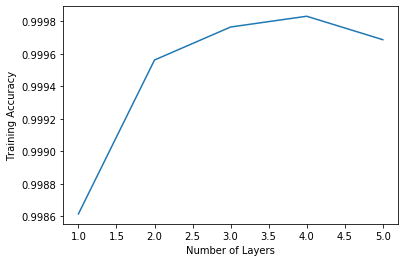

In [24]:
layers = [1,2,3,4,5]
plt.plot(layers, train_accuracies)
plt.xlabel("Number of Layers")
plt.ylabel("Training Accuracy")

Text(0, 0.5, 'Testing Accuracy')

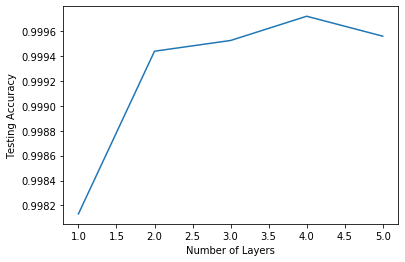

In [25]:
layers = [1,2,3,4,5]
plt.plot(layers, test_accuracies)
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy")

Text(0, 0.5, 'Average time per run')

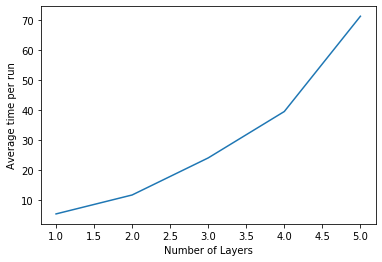

In [27]:
layers = [1,2,3,4,5]
plt.plot(layers, timings)
plt.xlabel("Number of Layers")
plt.ylabel("Average time per run")

In [30]:
total_time = 0
for i in range(5):
    total_time += timings[i]*10
print(total_time/60, " minutes")

25.31529750666666  minutes
